# BreastDCEDL_ISPY2 Nifti data

##  Data explore and Visualize
### Download full ISPY data from Zenodo

#### Author: Tomer Fridman
#### Date: 2025-09-17
> BreastDCEDL/ISPY2/BreastDCEDL_ISPY2_nifti_data.ipynb



In [93]:
from sklearn.metrics import classification_report,auc,roc_auc_score
from PIL import Image
import time
from pathlib import Path


import os
import numpy as np
import pandas as pd
from PIL import Image


import warnings


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from glob import glob
#from skimage import io
from sklearn.utils import shuffle

#from nipype.interfaces.ants import N4BiasFieldCorrection
import sys
import os
import ast


In [94]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
# cb - cotrast_brightness
def show_n_images(imgs, cmap='gray', titles = None, enlarge = 4, mtitle=None,
                  cut = 0, axis_off = True, fontsize=15, cb = 0):

    plt.set_cmap(cmap);

    n = len(imgs);
    gs1 = gridspec.GridSpec(1, n);

    fig1 = plt.figure(figsize=(4*len(imgs),8));
    for i in range(n):

        ax1 = fig1.add_subplot(gs1[i]);
        if (cb):
            if len(np.unique(imgs[i])<=5):
                 img = imgs[i]
            else:

                img = cont_br(imgs[i])
        else:
            img = imgs[i]
        if cut:
            ax1.imshow(img[50:290, 75:450] , interpolation='none', origin='lower');
        else:

            ax1.imshow(img, interpolation='none');
        if (titles is not None):
            ax1.set_title(titles[i], fontsize=fontsize);  #, fontweight="bold");
        if (axis_off):
            plt.axis('off')
    if mtitle:
        plt.title(mtitle)
    plt.tight_layout()
    plt.show();

In [95]:
def minmax(m):
    if m.max()==0:
        return m
    m = (m-m.min())/(m.max()-m.min())
    return m

def to_rgb(a,b,c):
    im=np.stack([minmax(a),
                minmax(b),
                minmax(c)], axis=2)
    return im

# Nifti data path

In [96]:
dce_dir = "zenodo_full_spy2/dce"

In [97]:
mask_dir = "zenodo_full_spy2/mask"

In [98]:
import os, sys

In [99]:
df=pd.read_csv('BreastDCEDL_ISPY2_metadata.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pid             982 non-null    object 
 1   pCR             982 non-null    float64
 2   n_xy            982 non-null    float64
 3   n_z             982 non-null    float64
 4   n_times         982 non-null    float64
 5   pre             982 non-null    float64
 6   post_early      982 non-null    float64
 7   post_late       982 non-null    float64
 8   slice_thick     982 non-null    float64
 9   xy_spacing      982 non-null    float64
 10  mask_start      982 non-null    float64
 11  mask_end        982 non-null    float64
 12  sraw            982 non-null    float64
 13  eraw            982 non-null    float64
 14  scol            982 non-null    float64
 15  ecol            982 non-null    float64
 16  tum_vol         982 non-null    float64
 17  age             982 non-null    flo

In [100]:
import nibabel as nib
import re
def read_niftii(fname):
    # Load the NIfTI file
    nii_img = nib.load(fname)

    # Get the data (as a NumPy array)
    mnii_data = nii_img.get_fdata()

    return mnii_data

In [101]:
def get_nifti_acquisitions(pid, data_path):
    
    im=[]
    ff = [x for x in os.listdir(data_path) if pid in x]
    if deb:print(ff)
    
    for f in ff:
        im.append(read_niftii(os.path.join(data_path, f)))
        
        
    return im

In [102]:
def extract_last_number(filename):
    # Match the LAST number in the filename, regardless of preceding character
    # Uses: \d+ = one or more digits, \. = literal dot, .* = any characters after
    match = re.search(r'(\d+)\.nii\.gz$', filename)
    return int(match.group(1)) if match else -1

In [103]:
def get_sorted_nifti_acquisitions(pid, data_path):
    
    ff = [x for x in os.listdir(data_path) if pid in x]
    if deb:print(os.listdir(data_path)[:7],pid)
    if deb:print(ff)
    sorted_filenames = sorted(ff, key=extract_last_number)
    
    img = []
    for f in sorted_filenames:
        x = read_niftii(os.path.join(data_path, f))
        img.append(x)
        
    return img

In [104]:
deb=0
df.sample(5)

pid  pCR   n_xy    n_z  n_times  pre  post_early  \
32   ACRIN-6698-218503  0.0  256.0   72.0      7.0  0.0         2.0   
872       ISPY2-831702  0.0  256.0  134.0      6.0  0.0         2.0   
323       ISPY2-154293  0.0  256.0   80.0      8.0  0.0         2.0   
274       ISPY2-109980  1.0  256.0   80.0      8.0  0.0         2.0   
186  ACRIN-6698-736721  0.0  256.0  160.0      7.0  0.0         2.0   

     post_late  slice_thick  xy_spacing  ...  race_white  race_black   HR  \
32         6.0          2.2    0.703100  ...         1.0         0.0  1.0   
872        5.0          1.2    0.742200  ...         0.0         0.0  1.0   
323        5.0          2.0    0.507800  ...         1.0         0.0  1.0   
274        6.0          2.0    0.781300  ...         1.0         0.0  1.0   
186        5.0          1.0    0.585938  ...         1.0         0.0  1.0   

     HER2  HR_HER2_STATUS  TripleNeg  HER2pos  HRposHER2neg  dataset  test  
32    0.0    HRposHER2neg        0.0      0.0           1.0     spy2   0.0  
872   1.0         HER2pos        0.0      1.0           0.0     spy2   1.0  
323   1.0         HER2pos        0.0      1.0           0.0     spy2   0.0  
274   1.0         HER2pos        0.0      1.0           0.0     spy2   0.0  
186   0.0    HRposHER2neg        0.0      0.0           1.0     spy2   1.0  

[5 rows x 29 columns]

## Visualize example

In [105]:
    import numpy as np
    import nibabel as nib

In [106]:
pid='ISPY2-149654'

In [107]:
df[df.pid==pid].T

316
pid             ISPY2-149654
pCR                      0.0
n_xy                   256.0
n_z                     80.0
n_times                  8.0
pre                      0.0
post_early               2.0
post_late                6.0
slice_thick              2.0
xy_spacing            0.5664
mask_start              10.0
mask_end                49.0
sraw                    72.0
eraw                   201.0
scol                   118.0
ecol                   208.0
tum_vol         29401.499566
age                48.751788
menopause                0.0
race_white               0.0
race_black               0.0
HR                       1.0
HER2                     0.0
HR_HER2_STATUS  HRposHER2neg
TripleNeg                0.0
HER2pos                  0.0
HRposHER2neg             1.0
dataset                 spy2
test                     0.0

In [108]:
        row = df[df.pid==pid].iloc[0] 
        
        smask=int(row['mask_start'])
        emask = int(row['mask_end'])
        pmask = (smask+emask)//2
        nz=int(row['n_z'])
        nxy=int(row['n_xy'])
        nt = int(row['n_times'])
        
            
        p0 = int(row['pre'])
        p1 = int(row['post_early'])
        p2 = int(row['post_late'])
        smask,emask,nz,nxy,nt,p0,p1,p2

(10, 49, 80, 256, 8, 0, 2, 6)

In [109]:
a=get_sorted_nifti_acquisitions(pid,  data_path=os.path.join(dce_dir, pid))
        
ma=get_nifti_acquisitions(pid,  data_path=mask_dir)

<Figure size 640x480 with 0 Axes>

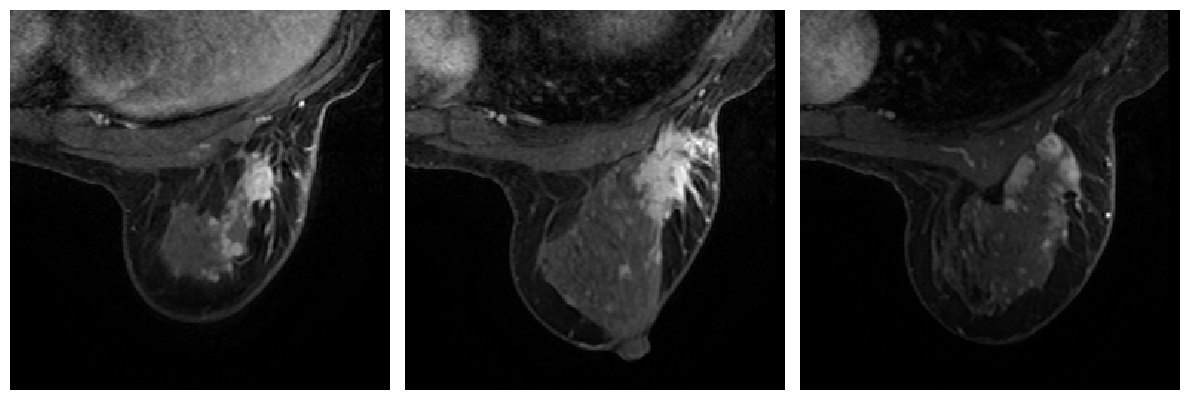

<Figure size 640x480 with 0 Axes>

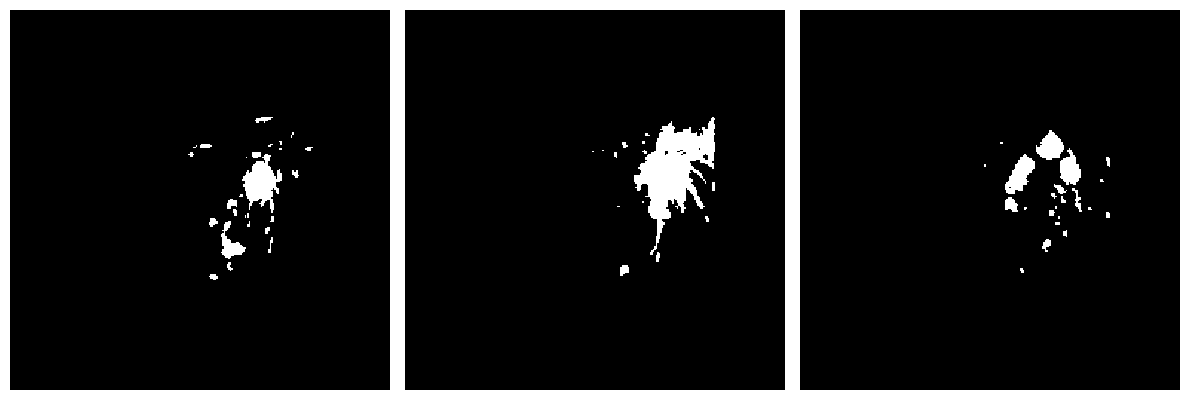

<Figure size 640x480 with 0 Axes>

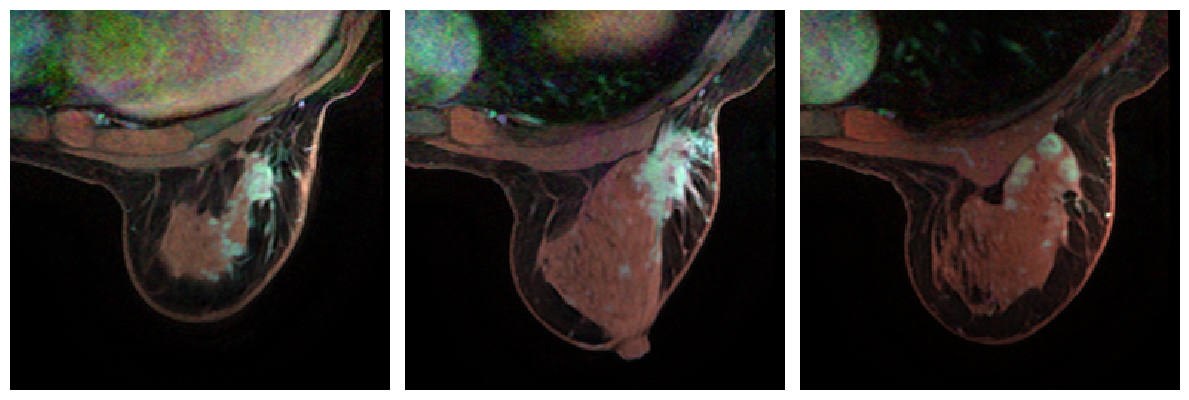

<Figure size 640x480 with 0 Axes>

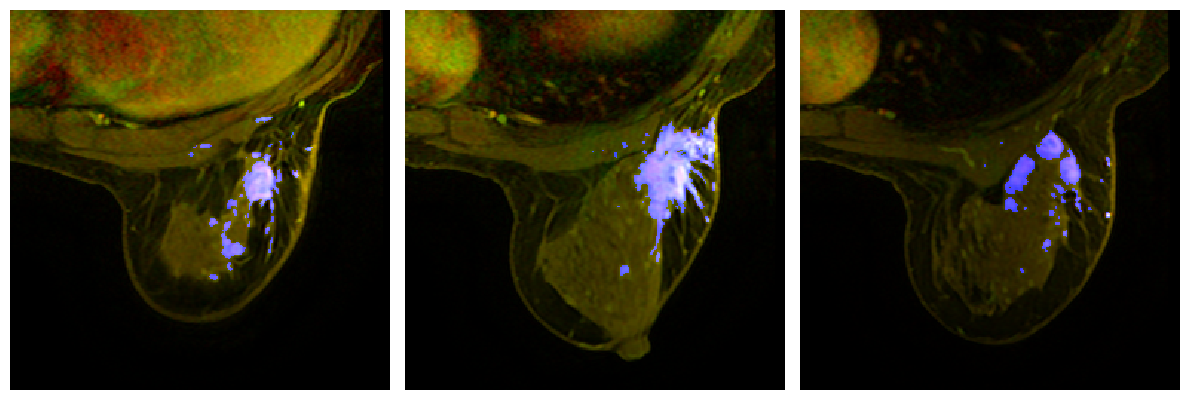

In [110]:
show_n_images([a[2][k] for k in [20,30,40]])
show_n_images([ma[0][k] for k in [20,30,40]])
show_n_images([to_rgb(a[0][k],a[1][k],a[2][k]) for k in [20,30,40]])
show_n_images([to_rgb(a[1][k],a[2][k],ma[0][k]) for k in [20,30,40]])

In [111]:
pid='ISPY2-375342'

In [112]:
df[df.pid==pid].T

496
pid             ISPY2-375342
pCR                      0.0
n_xy                   320.0
n_z                    180.0
n_times                  7.0
pre                      0.0
post_early               2.0
post_late                6.0
slice_thick              1.0
xy_spacing          0.703125
mask_start              89.0
mask_end               128.0
sraw                    53.0
eraw                   147.0
scol                   132.0
ecol                   204.0
tum_vol         14557.159424
age                     38.0
menopause                0.0
race_white               1.0
race_black               0.0
HR                       0.0
HER2                     0.0
HR_HER2_STATUS     TripleNeg
TripleNeg                1.0
HER2pos                  0.0
HRposHER2neg             0.0
dataset                 spy2
test                     0.0

In [113]:
        row = df[df.pid==pid].iloc[0] 
        
        smask=int(row['mask_start'])
        emask = int(row['mask_end'])
        pmask = (smask+emask)//2
        nz=int(row['n_z'])
        nxy=int(row['n_xy'])
        nt = int(row['n_times'])
        
            
        p0 = int(row['pre'])
        p1 = int(row['post_early'])
        p2 = int(row['post_late'])
        smask,emask,nz,nxy,nt,p0,p1,p2

(89, 128, 180, 320, 7, 0, 2, 6)

In [114]:
a=get_sorted_nifti_acquisitions(pid,  data_path=os.path.join(dce_dir, pid))
        
ma=get_nifti_acquisitions(pid,  data_path=mask_dir)

<Figure size 640x480 with 0 Axes>

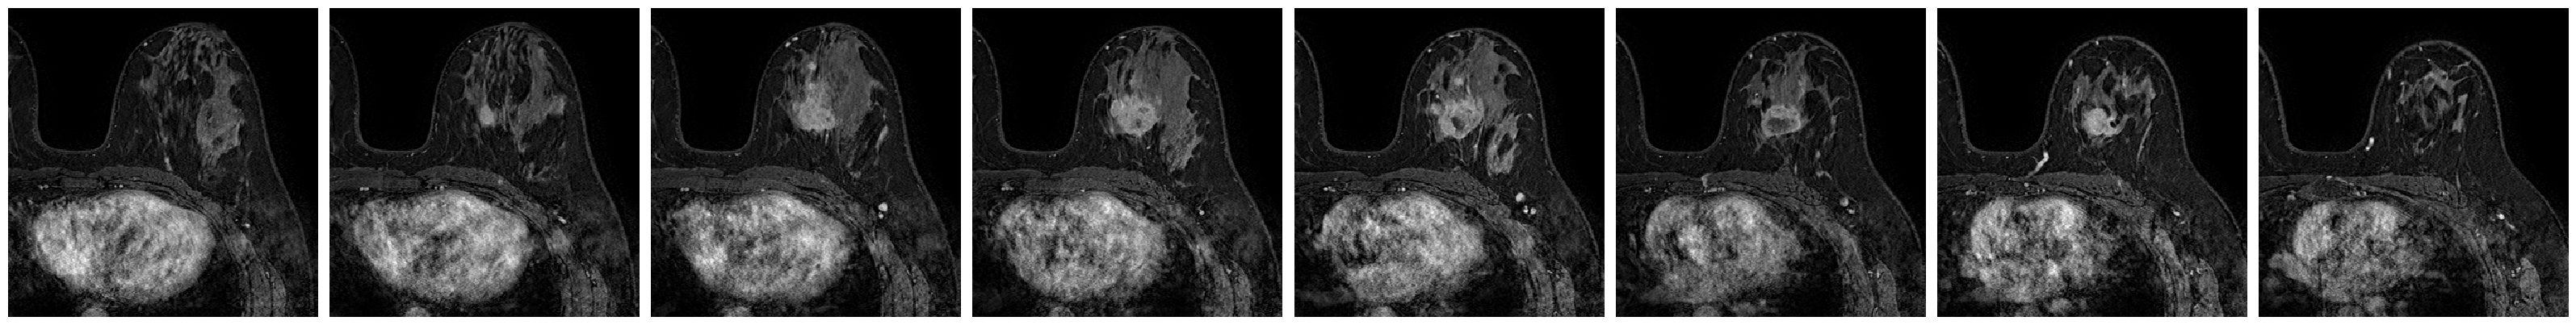

<Figure size 640x480 with 0 Axes>

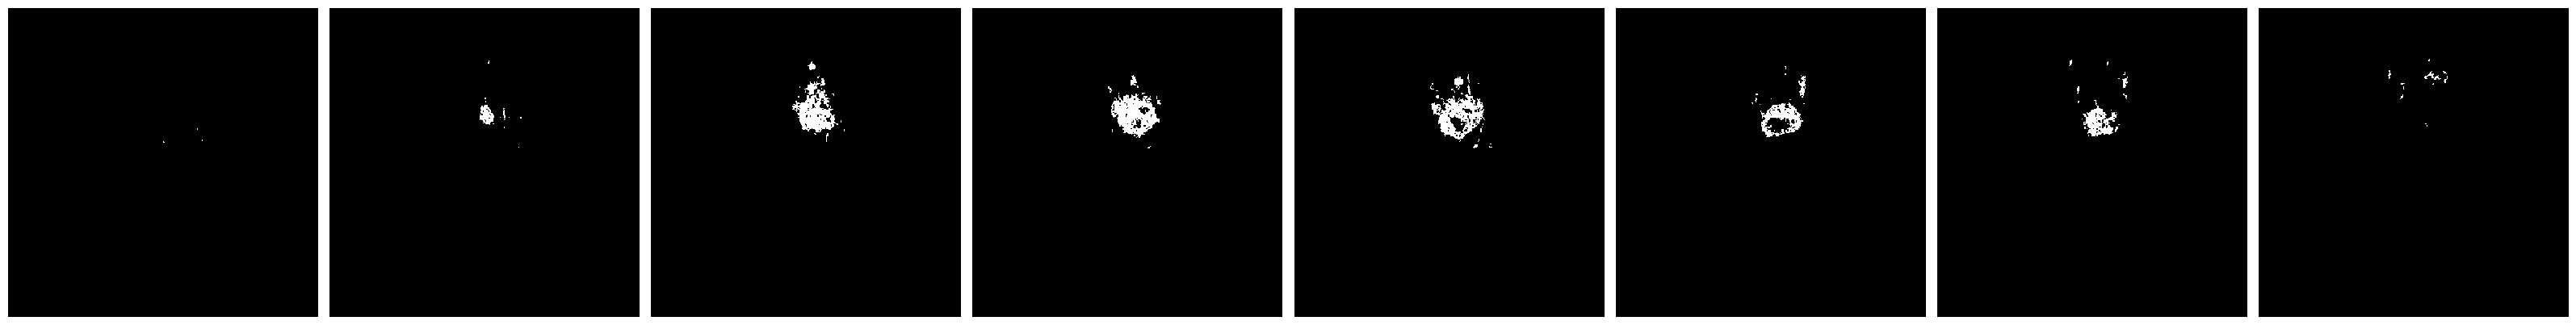

<Figure size 640x480 with 0 Axes>

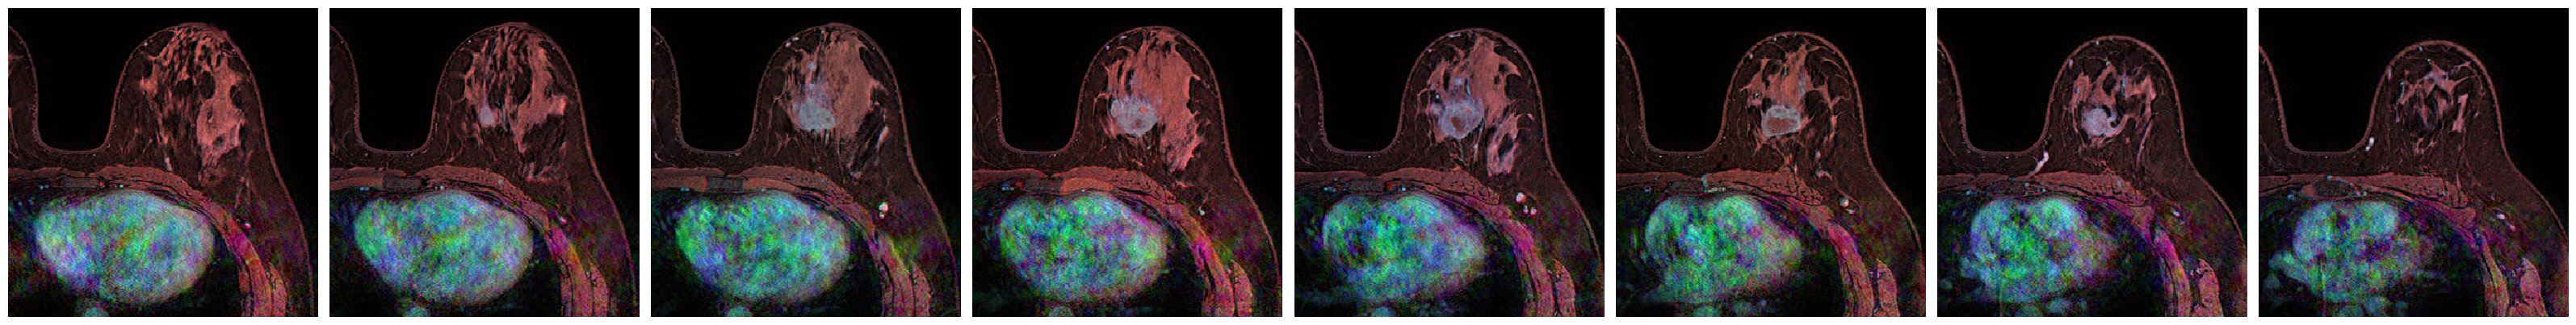

<Figure size 640x480 with 0 Axes>

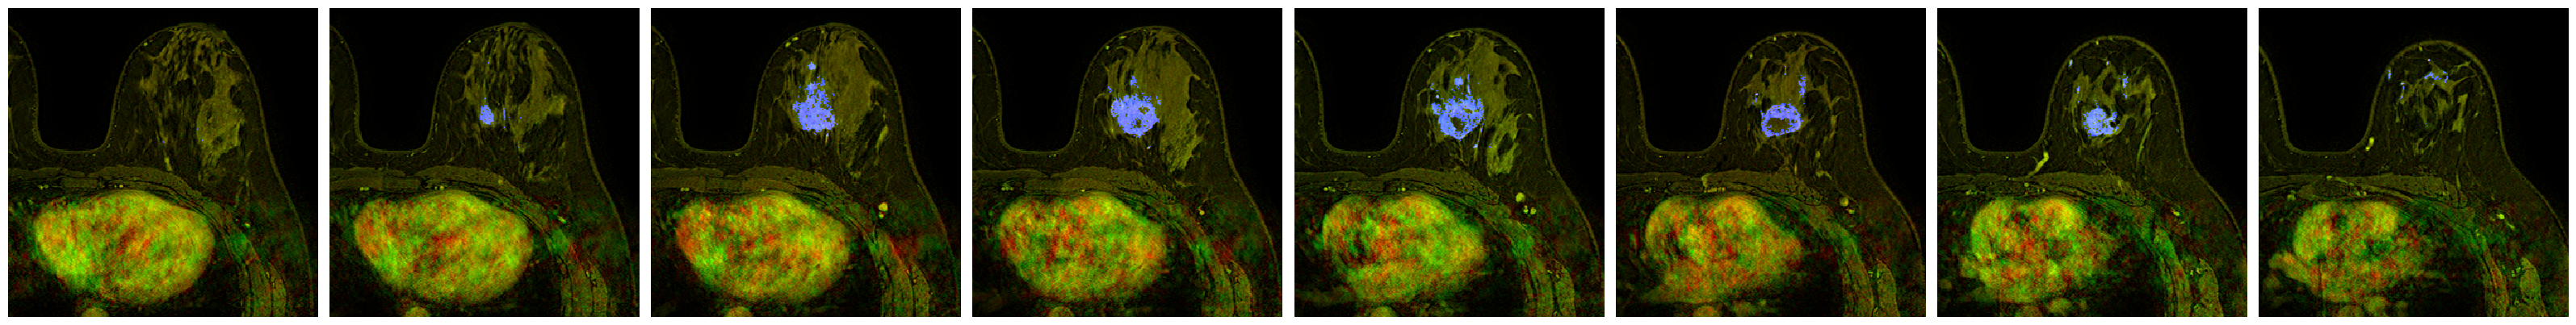

In [115]:
idx = range(smask, emask, 5)
show_n_images([a[2][k] for k in idx])
show_n_images([ma[0][k] for k in idx])
show_n_images([to_rgb(a[0][k],a[1][k],a[2][k]) for k in idx])
show_n_images([to_rgb(a[1][k],a[2][k],ma[0][k]) for k in idx])

## Sample creation 

In [116]:
sample_dir = "zenodo_full_spy2/spy2_samples"
os.makedirs(sample_dir, exist_ok=True)
create_samples = False

In [118]:
if create_samples:
    for i,row in df.iterrows():
        
        
        pid = row['pid']
        print('===',pid)
        smask=int(row['mask_start'])
        emask = int(row['mask_end'])
        pmask = (smask+emask)//2
        nz=int(row['n_z'])
        nxy=int(row['n_xy'])
        nt = int(row['n_times'])
        
        
        b=get_sorted_nifti_acquisitions(pid,  data_path=os.path.join(dce_dir, pid))
        
        mb=get_nifti_acquisitions(pid,  data_path=mask_dir)
            
        p0 = int(row['pre'])
        p1 = int(row['post_early'])
        p2 = int(row['post_late'])
        
        imf = to_rgb(b[p0][pmask],b[p2][pmask],mb[0][pmask])
        imf = (imf*255).astype(np.uint8)
        
        mfname  = pid+'_sample_'+str(pmask)+'.png'

            
        Image.fromarray(imf).save(os.path.join(sample_dir,  mfname))
        print('saved ',mfname)


saved  ACRIN-6698-591810_sample_59.png
=== ACRIN-6698-597907
saved  ACRIN-6698-597907_sample_21.png
=== ACRIN-6698-598835
saved  ACRIN-6698-598835_sample_82.png
=== ACRIN-6698-607843
saved  ACRIN-6698-607843_sample_14.png
=== ACRIN-6698-609151
saved  ACRIN-6698-609151_sample_44.png
=== ACRIN-6698-618717
saved  ACRIN-6698-618717_sample_78.png
=== ACRIN-6698-618860
saved  ACRIN-6698-618860_sample_118.png
=== ACRIN-6698-628788
saved  ACRIN-6698-628788_sample_87.png
=== ACRIN-6698-628823
saved  ACRIN-6698-628823_sample_40.png
=== ACRIN-6698-629371
saved  ACRIN-6698-629371_sample_52.png
=== ACRIN-6698-629606
saved  ACRIN-6698-629606_sample_82.png
=== ACRIN-6698-631299
saved  ACRIN-6698-631299_sample_47.png
=== ACRIN-6698-635632
saved  ACRIN-6698-635632_sample_20.png
=== ACRIN-6698-638126
saved  ACRIN-6698-638126_sample_40.png
=== ACRIN-6698-641246
saved  ACRIN-6698-641246_sample_54.png
=== ACRIN-6698-641697
saved  ACRIN-6698-641697_sample_75.png
=== ACRIN-6698-641977
saved  ACRIN-6698-64197

saved  ISPY2-105286_sample_57.png
=== ISPY2-105513
saved  ISPY2-105513_sample_87.png
=== ISPY2-108939
saved  ISPY2-108939_sample_62.png
=== ISPY2-109623
saved  ISPY2-109623_sample_47.png
=== ISPY2-109874
saved  ISPY2-109874_sample_62.png
=== ISPY2-109980
saved  ISPY2-109980_sample_41.png
=== ISPY2-111004
saved  ISPY2-111004_sample_51.png
=== ISPY2-111038
saved  ISPY2-111038_sample_40.png
=== ISPY2-111344
saved  ISPY2-111344_sample_98.png
=== ISPY2-111646
saved  ISPY2-111646_sample_44.png
=== ISPY2-111674
saved  ISPY2-111674_sample_36.png
=== ISPY2-111881
saved  ISPY2-111881_sample_86.png
=== ISPY2-112606
saved  ISPY2-112606_sample_88.png
=== ISPY2-114087
saved  ISPY2-114087_sample_42.png
=== ISPY2-115638
saved  ISPY2-115638_sample_87.png
=== ISPY2-116165
saved  ISPY2-116165_sample_39.png
=== ISPY2-117424
saved  ISPY2-117424_sample_84.png
=== ISPY2-117707
saved  ISPY2-117707_sample_26.png
=== ISPY2-119928
saved  ISPY2-119928_sample_69.png
=== ISPY2-120001
saved  ISPY2-120001_sample_35.p

saved  ISPY2-289107_sample_55.png
=== ISPY2-290413
saved  ISPY2-290413_sample_39.png
=== ISPY2-291515
saved  ISPY2-291515_sample_44.png
=== ISPY2-294176
saved  ISPY2-294176_sample_31.png
=== ISPY2-294265
saved  ISPY2-294265_sample_30.png
=== ISPY2-299364
saved  ISPY2-299364_sample_95.png
=== ISPY2-299840
saved  ISPY2-299840_sample_31.png
=== ISPY2-300724
saved  ISPY2-300724_sample_35.png
=== ISPY2-301289
saved  ISPY2-301289_sample_38.png
=== ISPY2-301968
saved  ISPY2-301968_sample_56.png
=== ISPY2-303685
saved  ISPY2-303685_sample_71.png
=== ISPY2-303947
saved  ISPY2-303947_sample_108.png
=== ISPY2-306127
saved  ISPY2-306127_sample_50.png
=== ISPY2-307659
saved  ISPY2-307659_sample_94.png
=== ISPY2-309830
saved  ISPY2-309830_sample_70.png
=== ISPY2-311316
saved  ISPY2-311316_sample_42.png
=== ISPY2-311455
saved  ISPY2-311455_sample_25.png
=== ISPY2-313243
saved  ISPY2-313243_sample_38.png
=== ISPY2-313672
saved  ISPY2-313672_sample_24.png
=== ISPY2-316996
saved  ISPY2-316996_sample_33.

saved  ISPY2-493519_sample_78.png
=== ISPY2-493775
saved  ISPY2-493775_sample_34.png
=== ISPY2-494022
saved  ISPY2-494022_sample_28.png
=== ISPY2-494296
saved  ISPY2-494296_sample_53.png
=== ISPY2-494946
saved  ISPY2-494946_sample_57.png
=== ISPY2-495440
saved  ISPY2-495440_sample_41.png
=== ISPY2-496205
saved  ISPY2-496205_sample_34.png
=== ISPY2-497010
saved  ISPY2-497010_sample_49.png
=== ISPY2-498024
saved  ISPY2-498024_sample_48.png
=== ISPY2-498985
saved  ISPY2-498985_sample_31.png
=== ISPY2-500826
saved  ISPY2-500826_sample_24.png
=== ISPY2-501303
saved  ISPY2-501303_sample_73.png
=== ISPY2-502486
saved  ISPY2-502486_sample_48.png
=== ISPY2-503034
saved  ISPY2-503034_sample_31.png
=== ISPY2-504838
saved  ISPY2-504838_sample_54.png
=== ISPY2-507198
saved  ISPY2-507198_sample_68.png
=== ISPY2-507249
saved  ISPY2-507249_sample_64.png
=== ISPY2-509012
saved  ISPY2-509012_sample_26.png
=== ISPY2-510543
saved  ISPY2-510543_sample_26.png
=== ISPY2-515105
saved  ISPY2-515105_sample_59.p

saved  ISPY2-666450_sample_35.png
=== ISPY2-666715
saved  ISPY2-666715_sample_60.png
=== ISPY2-668752
saved  ISPY2-668752_sample_51.png
=== ISPY2-672734
saved  ISPY2-672734_sample_47.png
=== ISPY2-674897
saved  ISPY2-674897_sample_54.png
=== ISPY2-676048
saved  ISPY2-676048_sample_51.png
=== ISPY2-676365
saved  ISPY2-676365_sample_103.png
=== ISPY2-676630
saved  ISPY2-676630_sample_78.png
=== ISPY2-677915
saved  ISPY2-677915_sample_43.png
=== ISPY2-679787
saved  ISPY2-679787_sample_125.png
=== ISPY2-683173
saved  ISPY2-683173_sample_28.png
=== ISPY2-683374
saved  ISPY2-683374_sample_73.png
=== ISPY2-683457
saved  ISPY2-683457_sample_105.png
=== ISPY2-685182
saved  ISPY2-685182_sample_21.png
=== ISPY2-685753
saved  ISPY2-685753_sample_40.png
=== ISPY2-687733
saved  ISPY2-687733_sample_39.png
=== ISPY2-689188
saved  ISPY2-689188_sample_10.png
=== ISPY2-690410
saved  ISPY2-690410_sample_40.png
=== ISPY2-692885
saved  ISPY2-692885_sample_68.png
=== ISPY2-697098
saved  ISPY2-697098_sample_5

saved  ISPY2-894128_sample_77.png
=== ISPY2-894491
saved  ISPY2-894491_sample_38.png
=== ISPY2-896621
saved  ISPY2-896621_sample_63.png
=== ISPY2-896939
saved  ISPY2-896939_sample_95.png
=== ISPY2-898618
saved  ISPY2-898618_sample_42.png
=== ISPY2-899381
saved  ISPY2-899381_sample_27.png
=== ISPY2-903880
saved  ISPY2-903880_sample_47.png
=== ISPY2-904269
saved  ISPY2-904269_sample_52.png
=== ISPY2-905264
saved  ISPY2-905264_sample_46.png
=== ISPY2-906042
saved  ISPY2-906042_sample_65.png
=== ISPY2-906795
saved  ISPY2-906795_sample_105.png
=== ISPY2-910188
saved  ISPY2-910188_sample_121.png
=== ISPY2-910706
saved  ISPY2-910706_sample_41.png
=== ISPY2-912836
saved  ISPY2-912836_sample_54.png
=== ISPY2-913225
saved  ISPY2-913225_sample_38.png
=== ISPY2-914968
saved  ISPY2-914968_sample_82.png
=== ISPY2-916586
saved  ISPY2-916586_sample_61.png
=== ISPY2-916645
saved  ISPY2-916645_sample_25.png
=== ISPY2-917762
saved  ISPY2-917762_sample_41.png
=== ISPY2-918979
saved  ISPY2-918979_sample_97